# 시작하기 전에...
* 파일-드라이브에 사본 저장

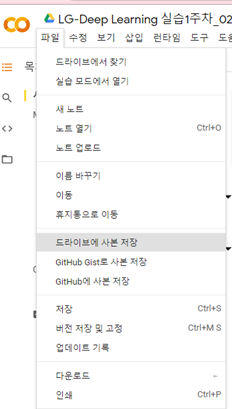

# Contents - Generative Model
## 1. AutoEncoder (AE)
## 2. Gernerative Adverserial Network (GAN)

# 실습 환경 구축
### 런타임 -> 런타임 유형 변경 -> 하드웨어 가속기 -> GPU로 변경

In [1]:
!nvidia-smi

Thu Apr 17 06:39:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. AutoEncoder(오토인코더)

AutoEncoder는 입력 데이터를 압축한 후 다시 복원하는 신경망 구조입니다.

- Input (입력층): 원본 데이터가 입력됩니다. 예: 이미지, 텍스트 벡터 등.

- Encoder (인코더): 입력 데이터를 점점 더 작은 차원으로 압축하며 특징을 추출합니다.
점점 작아지는 레이어를 통해 정보를 요약하며 잠재 공간(latent space) 으로 압축됩니다.

- Code (잠재 표현 / Bottleneck): 가장 압축된 형태의 데이터 표현입니다.
이 부분은 입력 데이터의 핵심 정보만 요약된 벡터로, 차원이 매우 작습니다.

- Decoder (디코더): 압축된 데이터를 다시 원래의 크기로 복원합니다.
Encoder와 대칭 구조를 가지며, 정보를 확장하여 최종 출력에 도달합니다.
Output (출력층): 인코더-디코더를 거쳐 복원된 데이터입니다.
입력과 유사하게 되도록 학습됩니다.

"AutoEncoder는 입력 데이터를 압축하고 다시 복원하는 비지도 학습 구조로, 데이터 압축, 잡음 제거, 특징 학습 등에 활용됩니다."


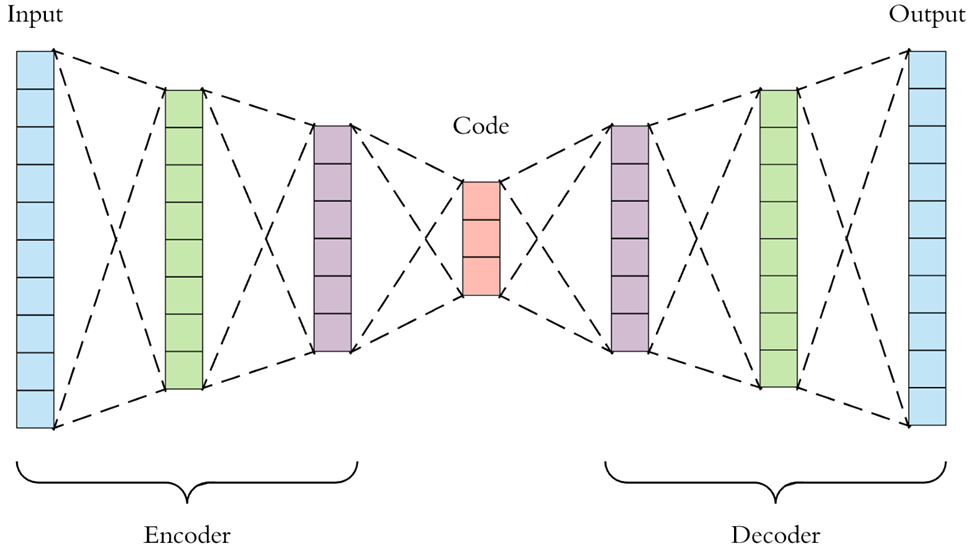

In [2]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D #생성되는 이미지를 관찰하기 위함입니다. 3차원 플롯을 그리는 용도입니다.
from matplotlib import cm # 데이터포인트에 색상을 입히는 것에 사용됩니다.
import numpy as np

In [3]:
# 하이퍼파라미터 준비
EPOCH = 20
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [4]:
# Fashion MNIST 데이터셋 불러오기 (학습데이터만 사용)
trainset = datasets.FashionMNIST(
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

In [5]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        #인코더는 간단한 신경망으로 분류모델처럼 생겼습니다.
        self.encoder = nn.Sequential( # nn.Sequential을 사용해 encoder와 decoder 두 모듈로 묶어줍니다.
            nn.Linear(28*28, 128), #차원을 28*28에서 점차 줄여나갑니다.
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다 (출력값이 바로 잠재변수가 됩니다.)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12), #디코더는 차원을 점차 28*28로 복원합니다.
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력하는 sigmoid()함수를 추가합니다.
        )

    def forward(self, x):
        encoded = self.encoder(x) # encoder는 encoded라는 잠재변수를 만들고
        decoded = self.decoder(encoded) # decoder를 통해 decoded라는 복원이미지를 만듭니다.
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
# Adam()을 최적화함수로 사용합니다. Adam은 SGD의 변형함수이며 학습중인 기울기를 참고하여 학습 속도를 자동으로 변화시킵니다.
criterion = nn.MSELoss() #원본값과 디코더에서 나온 값의 차이를 계산하기 위해 평균제곱오차(Mean Squared Loss) 오차함수를 사용합니다.

In [7]:
# 원본 이미지를 시각화 하기 (첫번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
# 복원이 어떻게 되는지 관찰하기 위해 5개의 이미지를 가져와 바로 넣어보겠습니다.
view_data = view_data.type(torch.FloatTensor)/255.
#픽셀의 색상값이 0~255이므로 모델이 인식하는 0부터 1사이의 값으로 만들기 위해 255로 나눠줍니다.

In [8]:
# 학습하기 위한 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE) #x(입력)와 y(대상 레이블)모두 원본이미지(x)인 것을 주의해야 합니다.
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) # decoded와 원본이미지(y) 사이의 평균제곱오차를 구합니다
        optimizer.zero_grad() #기울기에 대한 정보를 초기화합니다.
        loss.backward() # 기울기를 구합니다.
        optimizer.step() #최적화를 진행합니다.

[Epoch 1]


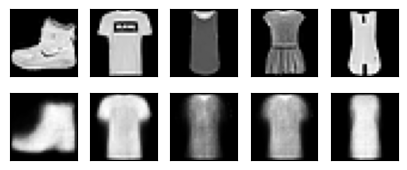

[Epoch 2]


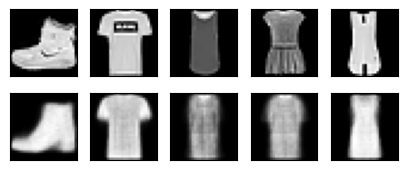

[Epoch 3]


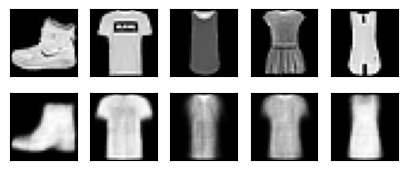

[Epoch 4]


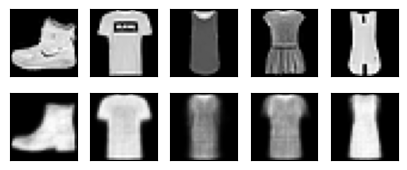

[Epoch 5]


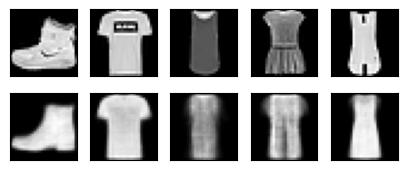

[Epoch 6]


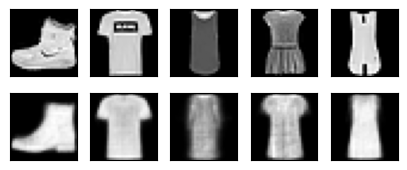

[Epoch 7]


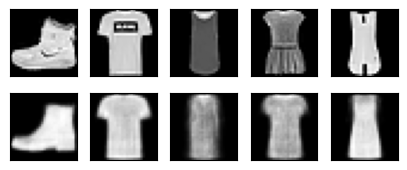

[Epoch 8]


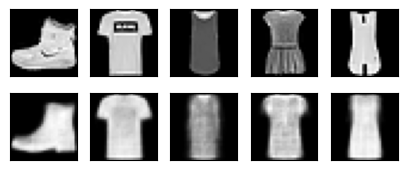

[Epoch 9]


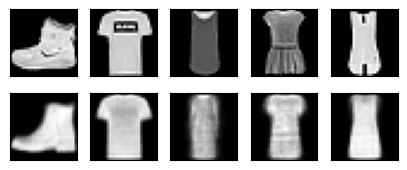

[Epoch 10]


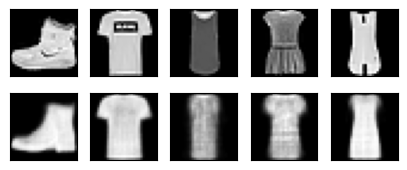

[Epoch 11]


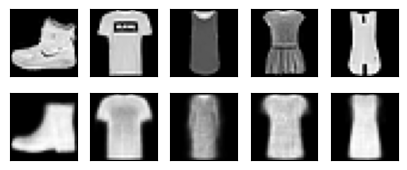

[Epoch 12]


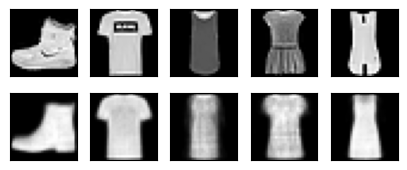

[Epoch 13]


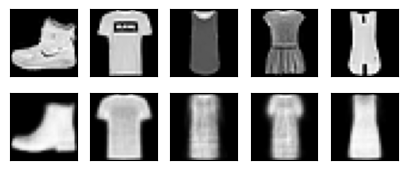

[Epoch 14]


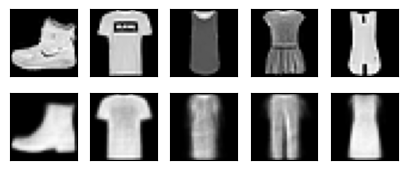

[Epoch 15]


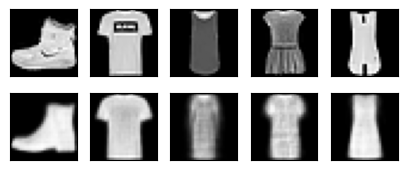

[Epoch 16]


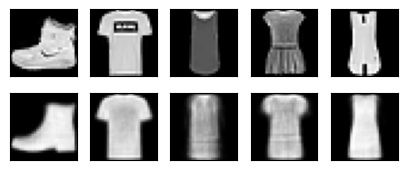

[Epoch 17]


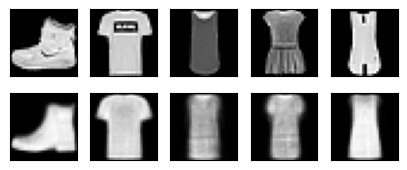

[Epoch 18]


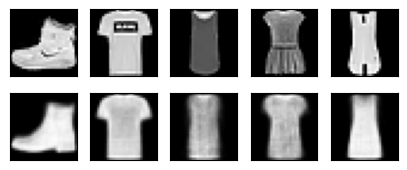

[Epoch 19]


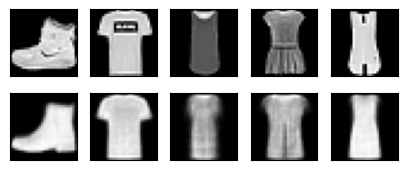

[Epoch 20]


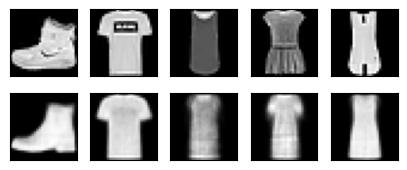

In [9]:
#학습하기
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기
    # 앞서 시각화를 위해 남겨둔 5개의 이미지를 한 이폭만큼 학습을 마친 모델에 넣어 복원이미지를 만듭니다.
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        # CUDA를 사용하면 모델 출력값이 GPU에 남아있으므로 .to("cpu") 함수로 일반메모리로 가져와 numpy행렬로 변환합니다.
        # cpu를 사용할때에도 같은 코드를 사용해도 무방합니다.
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

In [10]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28*28) #원본이미지 200개를 준비합니다
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

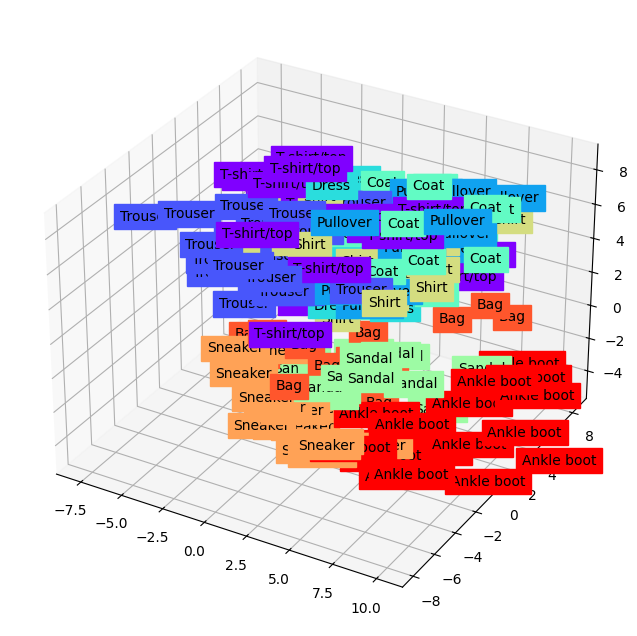

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 이건 유지
from matplotlib import cm

CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # ✅ 권장 방식

X = encoded_data[:, 0].detach().cpu().numpy()
Y = encoded_data[:, 1].detach().cpu().numpy()
Z = encoded_data[:, 2].detach().cpu().numpy()


labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(s / 9.0)  # ✅ 정규화된 값 사용
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())

#plt.savefig("latent_3d_plot.png", dpi=300)  # ✅ 저장
plt.show()

- 같은 레이블을 가진 이미지의 잠재변수는 확연히 서로 모임을 알 수 있습니다.
- 티셔츠, 드레스, 코트, 셔츠와 같은 윗옷들끼리의 거리는 가깝거나 겹치고, 신발류인 앵클부츠, 샌들, 운동화도 서로 가까이 자리하는 것을 볼 수 있습니다.
- 즉, 비슷한 의미의 이미지라면 공간적으로 더 까갑습니다.


# 오토인코더로 망가진 이미지 복원하기


- 앞서 오토인코더는 일종의 "압축"을 한다고 했습니다. 그리고 압축은 데이터의 특성에 중요도로 우선순위를 매기고 낮은 우선순위의 데이터를 버린다는 뜻이기도 합니다.

- 잡음제거 오토인코더의 아이디어는 중요한 특징을 추출하는 오토인코더의 특성을 이용하여 비교적 "덜 중요한 데이터"인 잡음을 버려 원래의 데이터를 복원한다는 것 입니다. 원래 배웠던 오토인코더와 큰 차이점은 없으며, 학습을 할때 입력에 잡음을 더하는 방식으로 복원 능력을 강화한 것이 핵심입니다.

- 앞서 다룬 코드와 동일하며 add_noise() 함수로 학습시 이미지에 노이즈를 더해주는 부분만 추가됐습니다.



In [12]:
# 잡음 더하기
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    # 무작위 작음은 torch.randn() 함수로 만들고 img.size()를 넣어 이미지와 같은 크기의 잡음을 만듭니다.
    # 잡음의 강도는 임의로 0.2로 정했습니다.
    noisy_img = img + noise
    return noisy_img

In [13]:
#학습코드에 노이즈더하기 코드 한줄을 추가합니다.
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)  # 입력에 노이즈 더하기
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() # 이번에는 평균 오찻값을 관찰하겠습니다.
    return avg_loss / len(train_loader)

In [14]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))
    # 이번 예제에선 학습시 시각화를 건너 뜁니다

[Epoch 1] loss:0.022462940212887233
[Epoch 2] loss:0.02207776008328713
[Epoch 3] loss:0.021909458060333852
[Epoch 4] loss:0.021860718782713163
[Epoch 5] loss:0.02187380711160807
[Epoch 6] loss:0.02170845302048205
[Epoch 7] loss:0.021679738500733365
[Epoch 8] loss:0.02176167038894856
[Epoch 9] loss:0.021627104706140852
[Epoch 10] loss:0.02166405240935621
[Epoch 11] loss:0.0215785602894006
[Epoch 12] loss:0.021543361872101006
[Epoch 13] loss:0.021890737831211295
[Epoch 14] loss:0.021679517473461533
[Epoch 15] loss:0.02168055348741665
[Epoch 16] loss:0.021711194947330172
[Epoch 17] loss:0.021563823346787296
[Epoch 18] loss:0.02158919559009294
[Epoch 19] loss:0.02164750459240571
[Epoch 20] loss:0.021576722106858612


In [15]:
# 잡음제거 시각화
# 모델이 학습시 본적이 없는 데이터로 검증하기 위해 테스트 데이터셋을 가져옵니다.
testset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False, #test데이터셋
    download  = True,
    transform = transforms.ToTensor()
)

# 테스트셋에서 이미지 한장을 가져옵니다.
sample_data = testset.data[2].view(-1, 28*28)
 #1차원 행렬로 변환합니다
sample_data = sample_data.type(torch.FloatTensor)/255.

# 이미지를 add_noise로 오염시킨 후, 모델에 통과시킵니다.
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x) #인코딩된 것은 무시하고 복원된 이미지만 보기 위해 첫 변수는 "_"로 이름 짓습니다.

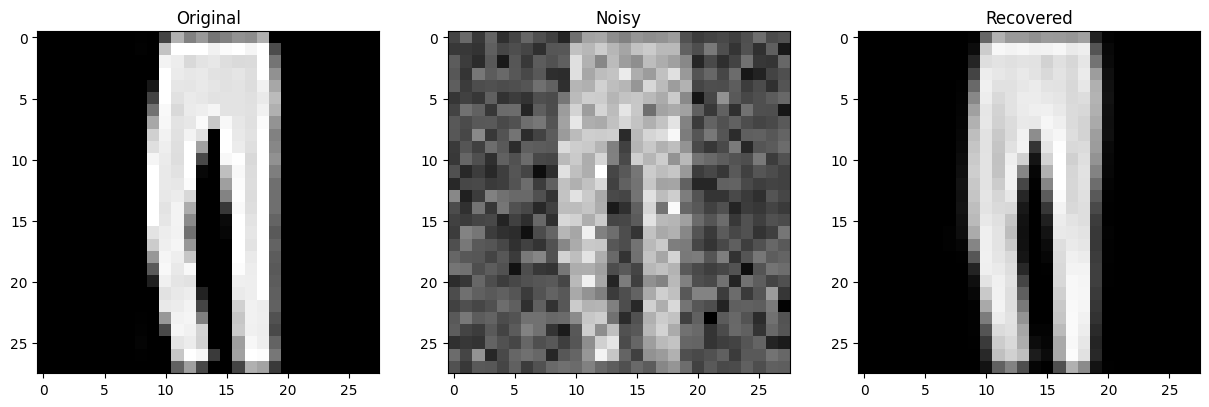

In [16]:
f, a = plt.subplots(1, 3, figsize=(15, 15)) #1행 3열의 표

# 시각화를 위해 넘파이 행렬로 바꿔줍니다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

#plt.savefig("denoise.png")
plt.show()

# GAN (Generative Adverserial Network)

GAN은 두 개의 모델이 서로 경쟁하며 학습하는 구조입니다.

1. Generator (G, 생성자)

- 랜덤한 잡음(Noise, z)을 받아서 가짜 데이터(Fake Money)를 생성합니다.

- 목표는 진짜처럼 보이는 데이터를 만들어내는 것입니다.

2. Discriminator (D, 판별자)

- 진짜 데이터(Real Money, x)와 생성된 가짜 데이터(G(z))를 구별합니다.

- 목표는 진짜와 가짜를 정확하게 판별하는 것입니다.

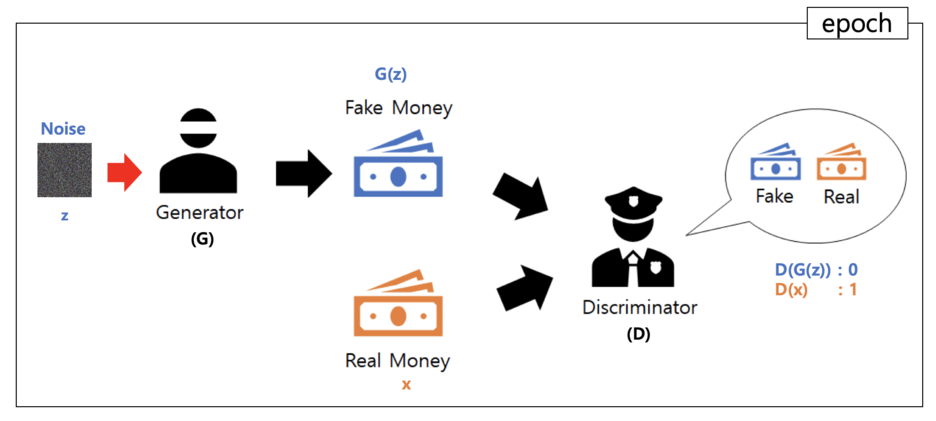

## DCGAN (Deep Convolutional Generative Adversarial Networks)

In [17]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # 결과 재현을 위해 필요합니다

Random Seed:  999


In [50]:
# 데이터셋의 경로
dataroot = "./data"

# dataloader에서 사용할 쓰레드 수
workers = 2

# 배치 크기
batch_size = 128

# 이미지의 크기입니다. 모든 이미지를 변환하여 64로 크기가 통일됩니다.
image_size = 64

# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 1

# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100

# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 64

# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 64

# 학습할 에폭 수
num_epochs = 5

# 옵티마이저의 학습률
lr = 0.0002

# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

In [51]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()])


# Fashion MNIST 데이터셋 불러오기 (학습데이터만 사용)
trainset = datasets.FashionMNIST(
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
    num_workers = 2
)

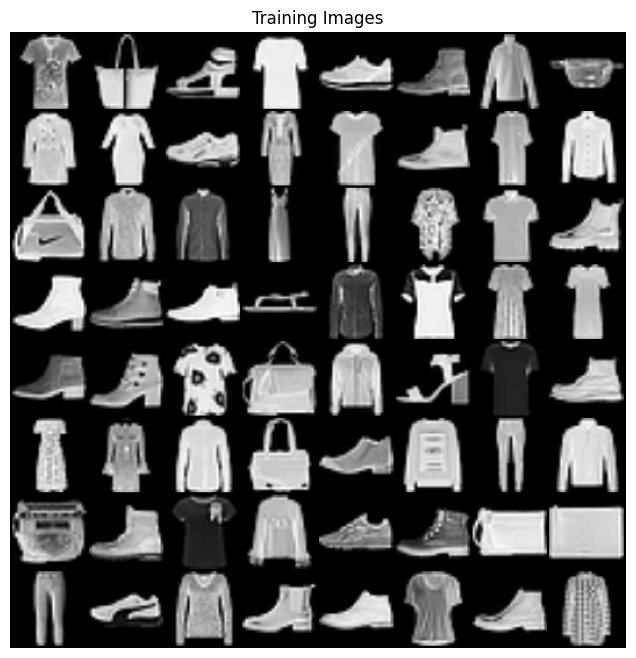

In [52]:
# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [53]:
# ``netG`` 와 ``netD`` 에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [54]:
# 생성자 코드

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 전치 합성곱 계층입니다.
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 위의 계층을 통과한 데이터의 크기. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [55]:
# 생성자를 만듭니다
netG = Generator(ngpu).to(device)

# 필요한 경우 multi-GPU를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 모든 가중치의 평균을 0( ``mean=0`` ), 분산을 0.02( ``stdev=0.02`` )로 초기화하기 위해
# ``weight_init`` 함수를 적용시킵니다
netG.apply(weights_init)

# 모델의 구조를 출력합니다
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [56]:
# 구분자 코드

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 ``(nc) x 64 x 64`` 입니다
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [57]:
# 구분자를 만듭니다
netD = Discriminator(ngpu).to(device)

# 필요한 경우 multi-GPU를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 모든 가중치의 평균을 0( ``mean=0`` ), 분산을 0.02( ``stdev=0.02`` )로 초기화하기 위해
# ``weight_init`` 함수를 적용시킵니다
netD.apply(weights_init)

# 모델의 구조를 출력합니다
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [58]:
# ``BCELoss`` 함수의 인스턴스를 초기화합니다
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 생성합니다
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [59]:
# 학습 과정

# 학습상태를 체크하기 위해 손실값들을 저장합니다
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        ###########################
        ## 진짜 데이터들로 학습을 합니다
        netD.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
        output = netD(real_cpu).view(-1)
        # 손실값을 구합니다
        errD_real = criterion(output, label)
        # 역전파의 과정에서 변화도를 계산합니다
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습을 합니다
        # 생성자에 사용할 잠재공간 벡터를 생성합니다
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성합니다
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별합니다
        output = netD(fake.detach()).view(-1)
        # D의 손실값을 계산합니다
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = netD(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.3887	Loss_G: 2.5552	D(x): 0.4729	D(G(z)): 0.3480 / 0.1006
[0/5][50/469]	Loss_D: 0.5822	Loss_G: 3.6618	D(x): 0.7289	D(G(z)): 0.0772 / 0.0551
[0/5][100/469]	Loss_D: 0.2533	Loss_G: 3.0596	D(x): 0.8663	D(G(z)): 0.0703 / 0.0677
[0/5][150/469]	Loss_D: 0.2229	Loss_G: 3.7036	D(x): 0.8880	D(G(z)): 0.0716 / 0.0445
[0/5][200/469]	Loss_D: 0.2430	Loss_G: 3.7220	D(x): 0.8776	D(G(z)): 0.0829 / 0.0474
[0/5][250/469]	Loss_D: 0.1278	Loss_G: 4.1904	D(x): 0.9251	D(G(z)): 0.0415 / 0.0264
[0/5][300/469]	Loss_D: 0.7227	Loss_G: 4.0225	D(x): 0.6286	D(G(z)): 0.0070 / 0.1162
[0/5][350/469]	Loss_D: 0.1844	Loss_G: 6.6039	D(x): 0.9688	D(G(z)): 0.1258 / 0.0043
[0/5][400/469]	Loss_D: 0.8073	Loss_G: 1.3527	D(x): 0.5554	D(G(z)): 0.0199 / 0.3373
[0/5][450/469]	Loss_D: 2.6805	Loss_G: 0.8634	D(x): 0.1474	D(G(z)): 0.0005 / 0.5690
[1/5][0/469]	Loss_D: 0.4554	Loss_G: 4.5743	D(x): 0.9162	D(G(z)): 0.2304 / 0.0691
[1/5][50/469]	Loss_D: 0.8803	Loss_G: 5.3972	D(x): 0.9650	D(G(z)): 

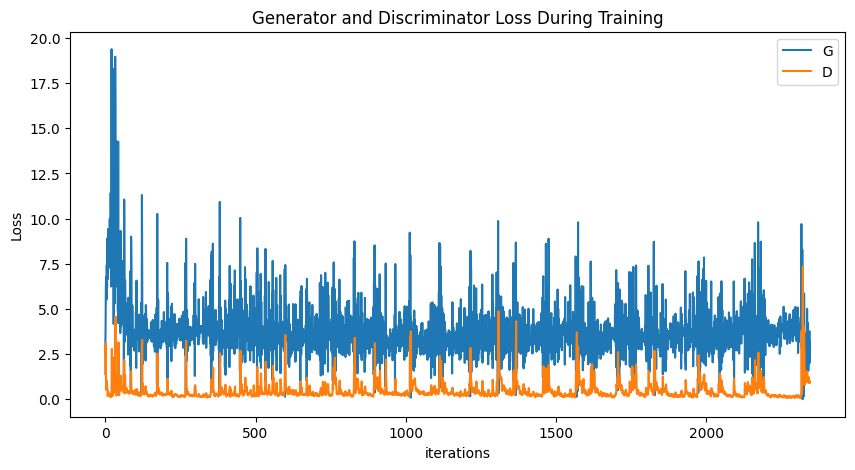

In [60]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [61]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

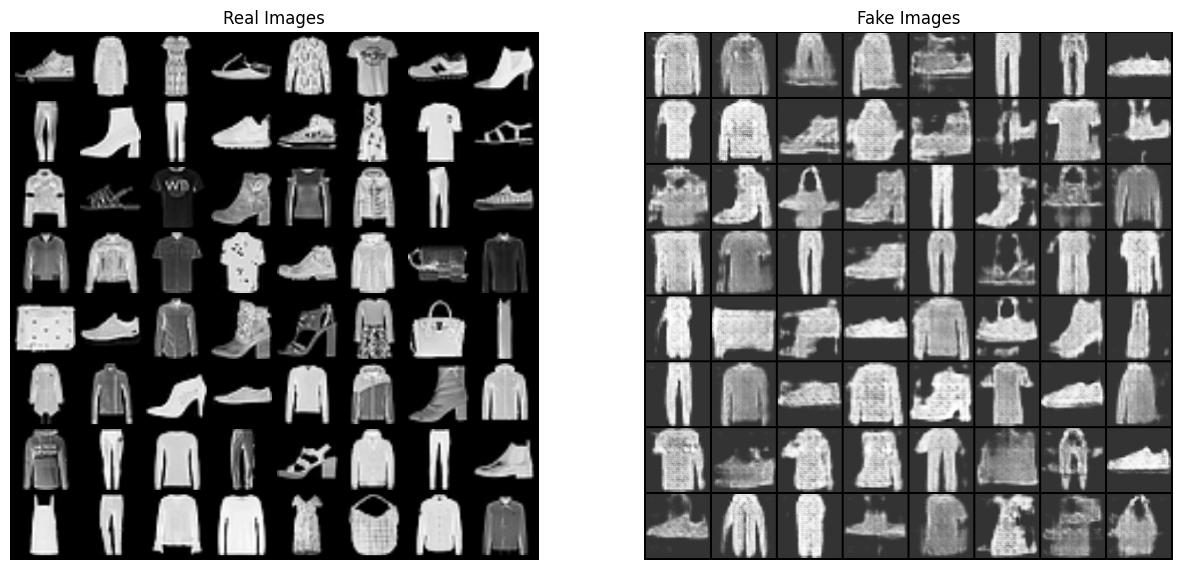

In [63]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(train_loader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()